<H1> Machine Learning Application </H1>

<H3>Libraries:

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle as pic
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.model_selection import train_test_split, cross_val_score, KFold

import warnings
warnings.filterwarnings('ignore')

<h3>Variables:

In [2]:
#classification = 'binary'
#classification = 'selected'
classification = 'all'
#classification = 'clinical'
#classification = 'non-clinical'

#train_file = 'train-'
train_file = 'wind-train-'
#train_file = 'feature-train-'

project = 'athena-i'
metric_file = 'metrics.csv'

dataset_path = "%s/%s/dataset/%s/" % (os.getenv('HOME'), project, classification)
result_path = "%s/%s/results-ii/%s/" % (os.getenv('HOME'), project, classification)

if classification == 'binary':
    classes = ["normal", "stress"]
    labels = [1, 2]
else:
    classes = ["pre-stress", "stress", "post-stress"]
    labels = [1, 2, 3]

<h3>Methods:

In [20]:
def load_dataset(path):
    x_train = pd.read_csv('%s%sx' % (path, train_file), delimiter=';')
    x_train = x_train.drop(columns=['AGE','WEIGHT','HEIGHT','BMI','PARTICIPANT','CLINICAL'])
    x_train = x_train.to_numpy()

    y_train = pd.read_csv('%s%sy' % (path, train_file), delimiter=';')
    y_train = y_train.to_numpy()

    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.33, random_state = 1)    

    return(x_train, y_train, x_test, y_test)

In [21]:
def get_metrics(y_test, y_predicted):
    data_metrics = []
    accuracy = metrics.accuracy_score(y_test, y_predicted)
    f1 = metrics.f1_score(y_test, y_predicted, average='weighted', pos_label=1)
    precision = metrics.precision_score(y_test, y_predicted, average='weighted', pos_label=1)
    recall = metrics.recall_score(y_test, y_predicted, average='weighted', pos_label=1)
    data_metrics.append(accuracy)
    data_metrics.append(f1)
    data_metrics.append(precision)
    data_metrics.append(recall)
    print("Accuracy: %.5f\tPrecision: %.5f\n" % (accuracy, precision))
    print("Recall: %.5f\t\tF1: %.5f" % (recall, f1))
    
    return data_metrics

In [22]:
def show_confusion_matrix(y_test, y_predicted, classifier, labels):   
    cm = confusion_matrix(y_test, y_predicted)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(cmn*100, 
                cmap='coolwarm',
                linecolor='white',
                linewidths=0.8,
                annot=True, 
                fmt='.3f', 
                xticklabels=classes, 
                yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('%s%s-confusion-matrix-percent.png' % (result_path, classifier))
    
    
    
    cm = confusion_matrix(y_test, y_predicted, labels)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(cm,
                cmap='Greys',
                annot=True, 
                fmt='.0f', 
                xticklabels=classes, 
                yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('%s%s-confusion-matrix.png' % (result_path, classifier))

In [23]:
def class_accuracy(y_test, y_predicted, classifier): 
    cm = confusion_matrix(y_test, y_predicted)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    f = open('%s%s-accuracy-per-class.txt' % (result_path, classifier), 'a')
    f.write("Class Accuracy\n")
    plt.show(block=False)
    index_acurácia = (cmn.diagonal())*100
    print('\nClass Accuracy')
    for i in range(len(index_acurácia)): 
        print('Class %s: %.2f' % (classes[i], index_acurácia[i]), '%')
        f.write(str('%.2f' %(index_acurácia[i])))
        f.write("\n")
    f.write("\n")
    f.close()

In [24]:
def weighted_accuracy(y_test, y_predicted, classifier): 
    valor = 0;
    cm = confusion_matrix(y_test, y_predicted)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Imprime a acurácia de cada classe
    f = open('%s%s-weighted-accuracy.txt' % (result_path, classifier), 'a')
    plt.show(block=False)
    index_acurácia = (cmn.diagonal())*100
    for i in range(len(index_acurácia)): 
        valor = valor + index_acurácia[i];
    valor = valor/len(index_acurácia);
    print('\nWeighted accuracy: %.2f' %(valor), '%')
    f.write(str('%.2f' %(valor)))
    f.write("\n")
    f.close()

In [25]:
def final_accuracy(y_test, y_predicted, classifier):
    score = accuracy_score(y_test, y_predicted)
    print('\nGeneral Accuracy: %.2f' % (score*100),'%')
    f = open('%s%s-general-accuracy.txt' % (result_path, classifier), 'a')
    f.write("Final accuracy: ")
    f.write(str('%.2f' %(score*100)))
    f.write("\n")

In [26]:
def cross_validation(model, classifier):
    print('\nCross Validation')
    SEED = 42

    np.random.seed(SEED)
    cv = KFold(n_splits = 5, shuffle = True)

    results = cross_val_score(model, x_train, 
                              y_train, cv = cv, scoring = 'accuracy')

    mean = results.mean()
    dv = results.std()
    
    string_out = "Average Accuracy: %.3f\n" % (mean*100)
    string_out += "Accuracy range: %.3f ~ %.3f\n\n" % ((mean - 2*dv)*100, (mean + 2*dv)*100)
    
    sys.stdout.write(string_out)

    f = open('%s%s-cross-validation.txt' % (result_path, classifier), 'a')
    f.write(string_out)

In [27]:
def export_model(model, classifier):
    try:
        pic.dump(model, open("%s%s.sav" % (result_path, classifier), 'wb'))
        sys.stdout.write("Export: Success\n\n")
    except TypeError:
        sys.stdout.write("Export: Fail\n\n")
        pass

In [28]:
def main(model, classifier):
    model.fit(x_train,y_train)
    export_model(model, classifier)
    y_predicted=model.predict(x_test)
    data_metrics[classifier] = get_metrics(y_test, y_predicted)
    final_accuracy(y_test, y_predicted, classifier)
    weighted_accuracy(y_test, y_predicted, classifier)
    class_accuracy(y_test, y_predicted, classifier)
    show_confusion_matrix(y_test, y_predicted, classifier, labels)
    cross_validation(model, classifier)

<H3>Call Methods:</H3>

Load Data

In [29]:
x_train, y_train, x_test, y_test = load_dataset(dataset_path)

In [30]:
data_metrics = pd.DataFrame(index=['Accuracy','F1','Precision','Recall'])

<H3>Machine Learning Application:</H3>

Decision Tree Classifier

Export: Success

Accuracy: 0.98781	Precision: 0.98781

Recall: 0.98781		F1: 0.98781

General Accuracy: 98.78 %

Weighted accuracy: 98.78 %

Class Accuracy
Class pre-stress: 98.64 %
Class stress: 98.66 %
Class post-stress: 99.04 %

Cross Validation
Average Accuracy: 98.242
Accuracy range: 98.218 ~ 98.265



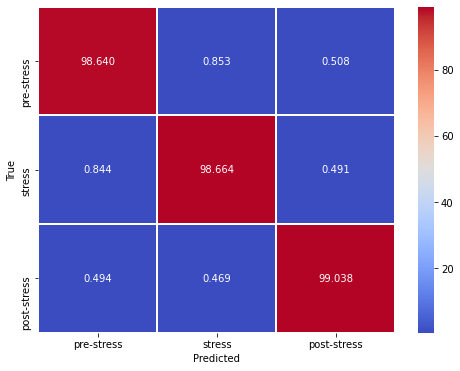

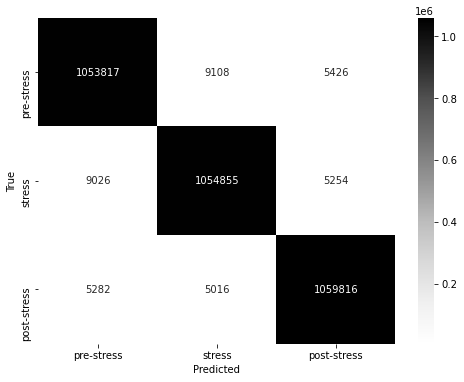

In [14]:
classifier = 'decision-tree-classifier'
model=DecisionTreeClassifier()
main(model, classifier)

KNN (KNeighbors Classifier)

Export: Success

Accuracy: 0.93810	Precision: 0.93815

Recall: 0.93810		F1: 0.93812

General Accuracy: 93.81 %

Weighted accuracy: 93.81 %

Class Accuracy
Class pre-stress: 93.32 %
Class stress: 93.64 %
Class post-stress: 94.47 %

Cross Validation
Average Accuracy: 93.111
Accuracy range: 93.092 ~ 93.130



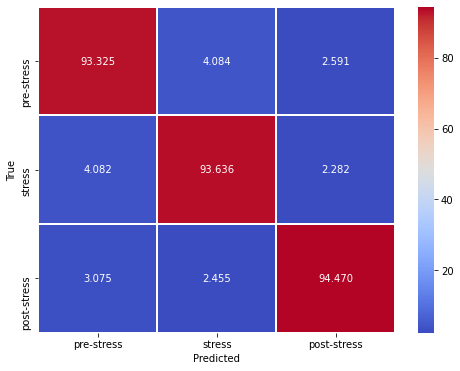

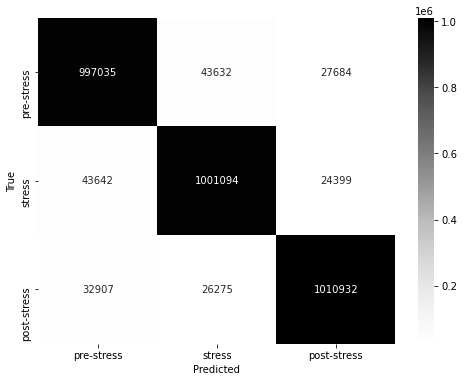

In [15]:
classifier = 'kneighbors-classifier'
model=KNeighborsClassifier()
main(model, classifier)

Random Forest Classifier

In [ ]:
classifier = 'random-forest-classifier'
model=RandomForestClassifier()
main(model, classifier)

AdaBoostClassifier

In [ ]:
classifier = 'ada-boost-classifier'
model=AdaBoostClassifier()
main(model, classifier)

MLPClassifier

In [ ]:
classifier = 'mlp-classifier'
model=MLPClassifier()
main(model, classifier)

SVC

In [ ]:
classifier = 'svc'
model=SVC()
main(model, classifier)

GaussianProcessClassifier

In [ ]:
classifier = 'gaussian-process-classifier'
model=GaussianProcessClassifier()
main(model, classifier)

GaussianNB

In [ ]:
classifier = 'gaussian-naive-bayes'
model=GaussianNB()
main(model, classifier)

In [ ]:
data_metrics.to_csv('%s%s' % (result_path, metric_file), index=True, header=True, sep=';', encoding='utf-8')